In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from matplotlib.ticker import FormatStrFormatter
import re
import os
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import math

In [2]:
file_path = 'Figure 7 and Table 1 (4953).csv'
data = pd.read_csv(file_path)
print(data.to_string(index=False))

 Adjusted JD (Spline)   Interpolated RA (Spline)
             0.000000                  10.864322
             0.039598                  10.842719
             0.079196                  10.821097
             0.118795                  10.799487
             0.158393                  10.777918
             0.197991                  10.756420
             0.237589                  10.735022
             0.277187                  10.713754


In [3]:
jd_adjusted = data['Adjusted JD (Spline)']
jd_binned_median = jd_adjusted - jd_adjusted.min()

ra_deg_adjusted_detected = data[' Interpolated RA (Spline)']

print(f"{'JD Adjusted':<25}{'RA Adjusted Detected':<25}")
print("=" * 75)

for jd, ra in zip(jd_binned_median, ra_deg_adjusted_detected):
    print(f"{jd:<25.10f}{ra:<25.10f}")

JD Adjusted              RA Adjusted Detected     
0.0000000000             10.8643220000            
0.0395980000             10.8427190000            
0.0791960000             10.8210970000            
0.1187950000             10.7994870000            
0.1583930000             10.7779180000            
0.1979910000             10.7564200000            
0.2375890000             10.7350220000            
0.2771870000             10.7137540000            


In [4]:
#  Equation 5
def fit_function_linear(x, A, B, C, D):
    return A * np.sin(2 * np.pi * x + B) + C * x + D

params_sine, covariance_sine = curve_fit(fit_function_linear, jd_binned_median, ra_deg_adjusted_detected)
print(f"\033[1;32m Equation 1: sine +linear terms (Paramters):     {params_sine}\033[0m")

# Uncertainties in Equation 5
sine_uncertainties = np.sqrt(np.diag(covariance_sine))
print(f"\033[1;32m Equation 1: sine +linear terms (Uncertainities):{sine_uncertainties}\033[0m")

 Equation 1: sine +linear terms (Paramters):     [-2.23609146e-03 -6.70800116e+00 -5.32068397e-01  1.08633988e+01]
 Equation 1: sine +linear terms (Uncertainities):[4.83756697e-05 1.08657567e-02 3.05183431e-04 4.29121693e-05]


In [5]:
amplitude_deg = params_sine[0]
amplitude_rad = math.radians(amplitude_deg)
print(f"\033[1;32mamplitude (rad):              {amplitude_rad}\033[0m")
 
amplitude_uncertainty_deg = sine_uncertainties[0]
amplitude_uncertainty_rad = math.radians(amplitude_uncertainty_deg)
print(f"\033[1;32mamplitude uncertianity (rad): {amplitude_uncertainty_rad}\033[0m")

amplitude (rad):              -3.9027158402455246e-05
amplitude uncertianity (rad): 8.44314714841338e-07


In [6]:
earth_radius_km = 6371  

distance_km = earth_radius_km / amplitude_rad

distance_uncertainty_km = (earth_radius_km/amplitude_rad) * (amplitude_uncertainty_rad/abs(amplitude_rad))

print(f"\033[1;32mEquation 3: Distance_km: {abs(distance_km):.2f} ± {abs(distance_uncertainty_km):.2f}\033[0m")

Equation 3: Distance_km: 163245295.35 ± 3531653.61


In [7]:
latitude_deg = 30.1732 
latitude_rad = math.radians(latitude_deg)
print("Latitude (rad):              ", latitude_rad)

Latitude (rad):               0.526621685862753


In [8]:
dec_deg = 36.743048
dec_rad = math.radians(dec_deg)
print("DEC (rad):                   ", dec_rad)

DEC (rad):                    0.6412871648183175


In [9]:
asteroid_km = (distance_km * math.cos(latitude_rad)) / math.cos(dec_rad)

asteroid_uncertainty_km = asteroid_km * (distance_uncertainty_km / distance_km)

print(f"\033[1;32mEquation 4: Asteroid Distance (km):{abs(asteroid_km):.2f} ± {abs(asteroid_uncertainty_km):.2f}\033[0m")

Equation 4: Asteroid Distance (km):176116983.66 ± 3810120.10


In [10]:
km_to_au = 149597870.7

asteroid_dist_au = asteroid_km / km_to_au

asteroid_dist_uncertainty_au = asteroid_uncertainty_km / km_to_au

print(f"\033[1;32mAsteroid Distance (AU):{abs(asteroid_dist_au):.6f} ± {abs(asteroid_dist_uncertainty_au):.6f}\033[0m")

Asteroid Distance (AU):1.177269 ± 0.025469


In [11]:
true_distance = 1.146913
print(f"\033[1;32mNASA JPL Horizons True distance (AU): {true_distance}\033[0m")

NASA JPL Horizons True distance (AU): 1.146913


In [12]:
if asteroid_dist_au == 0 or true_distance == 0:
    print("\033[1;31mError: One of the values is zero, cannot compute percentage difference.\033[0m")
else:
    percentage_difference = abs(abs(asteroid_dist_au) - abs(true_distance)) / ((abs(asteroid_dist_au) + abs(true_distance)) / 2) * 100
    print(f"\033[1;32mAsteroid Distance Difference between True and Predicted: {percentage_difference:.6f}%\033[0m")

Asteroid Distance Difference between True and Predicted: 2.612215%


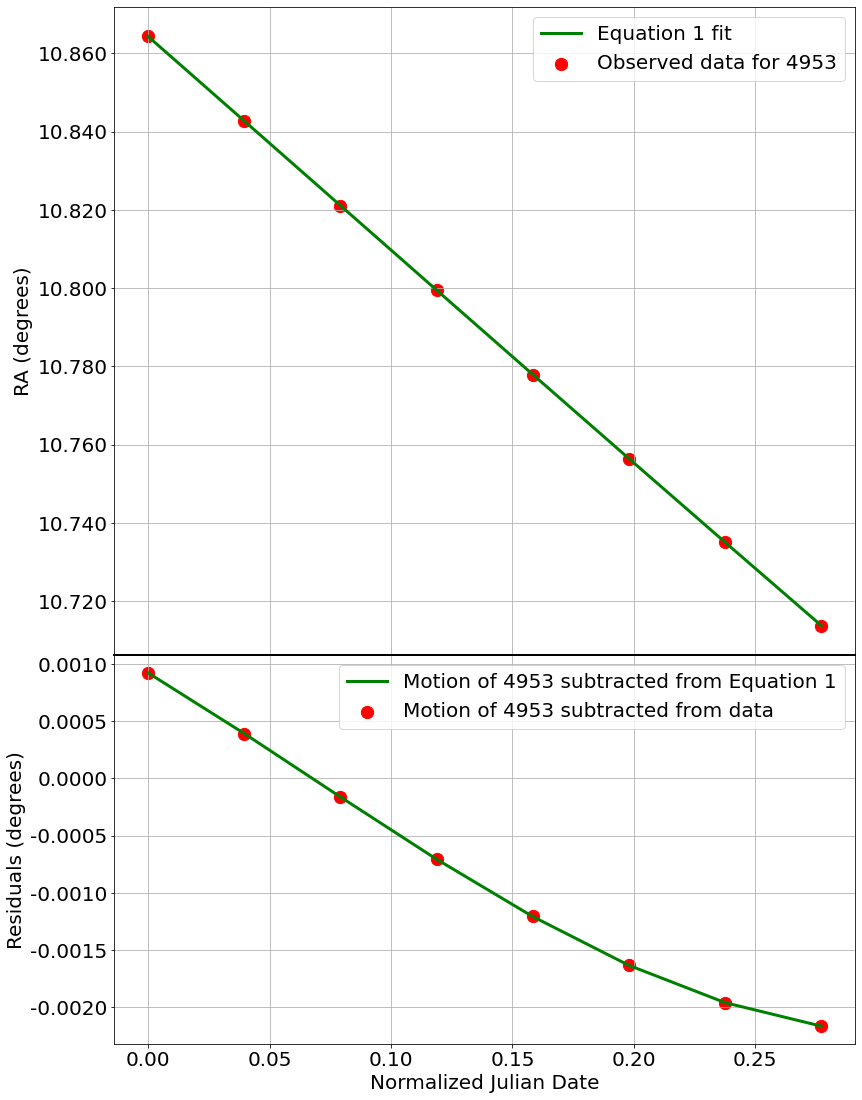

In [13]:
fig = plt.figure(figsize=(12.1, 18))
gs = GridSpec(3, 1, height_ratios=[10, 6, 1], figure=fig)

# Subplot 1: 
ax1 = fig.add_subplot(gs[0, 0])

ax1.scatter(jd_binned_median, ra_deg_adjusted_detected, color='red', label = 'Observed data for 4953', s = 150)
ax1.plot(jd_binned_median, fit_function_linear(jd_binned_median, *params_sine), color='green', label = 'Equation 1 fit', linewidth = 3)

ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_ylabel("RA (degrees)", fontsize=20)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax1.set_xticklabels([])
ax1.legend(fontsize=20)
ax1.grid()

# Subplot 2: 
ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(jd_binned_median, 
         fit_function_linear(jd_binned_median, *params_sine) - (params_sine[2]*jd_binned_median + params_sine[3]), 
         color = 'green', label = 'Motion of 4953 subtracted from Equation 1', linewidth = 3)
ax2.scatter(jd_binned_median, ra_deg_adjusted_detected - (params_sine[2]*jd_binned_median + params_sine[3]), 
            color = 'red', label = 'Motion of 4953 subtracted from data', s = 150)

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_xlabel("Normalized Julian Date", fontsize=20)
ax2.set_ylabel("Residuals (degrees)", fontsize=20) 
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax2.legend(fontsize=20)
ax2.grid()

plt.subplots_adjust(hspace=0)
plt.gcf().axes[0].spines['bottom'].set_linewidth(2)
plt.gcf().axes[1].spines['top'].set_linewidth(2)

plt.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.1, hspace=0)
plt.savefig("Figure 7.png", format="png", dpi=300, bbox_inches="tight", facecolor='white')

plt.show()